In [40]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

In [41]:
df = pd.read_csv("Filghts TEC_Valid.csv")

Borramos los datos mayores del 2023 por que esos se predicen. Se guardan para la hora de prediccion

In [42]:
df['STD'] = pd.to_datetime(df['STD'])
df['STA'] = pd.to_datetime(df['STA'])

In [43]:
datos2024 = df.loc[df['STD'].dt.year > 2024]

In [44]:
df = df[df['STD'].dt.year < 2024]

Se borran los datos que no tengan informacion de la aeronave.

In [45]:
df = df.dropna()

Encontramos el tiempo del vuelo para hacer una nueva columna, ya que consideramos que implica para calcular los pasajeros y los aarticulos, consecuentemente.

In [46]:
df['tiempoVuelo'] = df['STA'] - df['STD']
df['tiempoVuelo'] = df['tiempoVuelo'] / np.timedelta64(1, 'm')
datos2024['tiempoVuelo'] = datos2024['STA'] - datos2024['STD']
datos2024['tiempoVuelo'] = datos2024['tiempoVuelo'] / np.timedelta64(1, 'm')

Consideramos que los datos de Aeronave no implican en el numero de pasajeros y bookings, ya que la mayoria de personas no se enfoca en el tipo de aeronave.

In [47]:
columns_to_encode = [ "Destination_Type", "Origin_Type"]
df = pd.concat([df, pd.get_dummies(df[columns_to_encode])], axis=1)
df.drop(columns=columns_to_encode, inplace=True)
df.drop(columns=["Aeronave",'DepartureStation', "ArrivalStation"], inplace=True)

Codificamos el tipo de destino y el tipo de origen para que la clasificación tenga un valor de 0 y 1.

In [48]:
columns_to_encode = [ "Destination_Type", "Origin_Type"]
datos2024 = pd.concat([datos2024, pd.get_dummies(datos2024[columns_to_encode])], axis=1)
datos2024.drop(columns=columns_to_encode, inplace=True)
datos2024.drop(columns=["Aeronave",'DepartureStation', "ArrivalStation"], inplace=True)


Por que tienen una naturaleza ciclica mediante la codificacion de senos y cosenos ayudamos a la red neuronal a entender la continuidad a travez del final y comienzo de estos ciclicos.

In [49]:
df['hour_sinSalida'] = np.sin(2 * np.pi * df['STD'].dt.hour / 24)
df['hour_cosSalida'] = np.cos(2 * np.pi * df['STD'].dt.hour / 24)
df['day_of_week_sinSalida'] = np.sin(2 * np.pi *  df['STD'].dt.dayofweek / 7)
df['day_of_week_cosSalida'] = np.cos(2 * np.pi *  df['STD'].dt.dayofweek / 7)
df['month_sinSalida'] = np.sin(2 * np.pi * df['STD'].dt.month / 12)
df['month_cosSalida'] = np.cos(2 * np.pi * df['STD'].dt.month/ 12)
df.drop(columns="STD", inplace=True)

In [50]:
df['hour_sinLlegada'] = np.sin(2 * np.pi * df['STA'].dt.hour / 24)
df['hour_cosLlegada'] = np.cos(2 * np.pi * df['STA'].dt.hour / 24)
df['day_of_week_sinLlegada'] = np.sin(2 * np.pi *  df['STA'].dt.dayofweek / 7)
df['day_of_week_cosLlegada'] = np.cos(2 * np.pi *  df['STA'].dt.dayofweek / 7)
df['month_sinLlegada'] = np.sin(2 * np.pi * df['STA'].dt.month / 12)
df['month_cosLlegada'] = np.cos(2 * np.pi * df['STA'].dt.month/ 12)
df.drop(columns="STA", inplace=True)

In [51]:
datos2024['hour_sinSalida'] = np.sin(2 * np.pi * datos2024['STD'].dt.hour / 24)
datos2024['hour_cosSalida'] = np.cos(2 * np.pi * datos2024['STD'].dt.hour / 24)
datos2024['day_of_week_sinSalida'] = np.sin(2 * np.pi *  datos2024['STD'].dt.dayofweek / 7)
datos2024['day_of_week_cosSalida'] = np.cos(2 * np.pi *  datos2024['STD'].dt.dayofweek / 7)
datos2024['month_sinSalida'] = np.sin(2 * np.pi * datos2024['STD'].dt.month / 12)
datos2024['month_cosSalida'] = np.cos(2 * np.pi * datos2024['STD'].dt.month/ 12)
datos2024.drop(columns="STD", inplace=True)

In [52]:
datos2024['hour_sinLlegada'] = np.sin(2 * np.pi * datos2024['STA'].dt.hour / 24)
datos2024['hour_cosLlegada'] = np.cos(2 * np.pi * datos2024['STA'].dt.hour / 24)
datos2024['day_of_week_sinLlegada'] = np.sin(2 * np.pi *  datos2024['STA'].dt.dayofweek / 7)
datos2024['day_of_week_cosLlegada'] = np.cos(2 * np.pi *  datos2024['STA'].dt.dayofweek / 7)
datos2024['month_sinLlegada'] = np.sin(2 * np.pi * datos2024['STA'].dt.month / 12)
datos2024['month_cosLlegada'] = np.cos(2 * np.pi * datos2024['STA'].dt.month/ 12)
datos2024.drop(columns="STA", inplace=True)

Si el vuelo se sobrevendió se deja como la maxima capacidad, para no entrenar al modelo a sobrevender los vuelos.

In [53]:
df1 = df

In [54]:
df1['Passengers'] = df1.apply(lambda row: row['Capacity'] if row['Passengers'] > row['Capacity'] else row['Passengers'], axis=1)

Borramos los outliers de los vuelos con pocos pasajeros, para que solo trabajemos con los vuelos "reales".

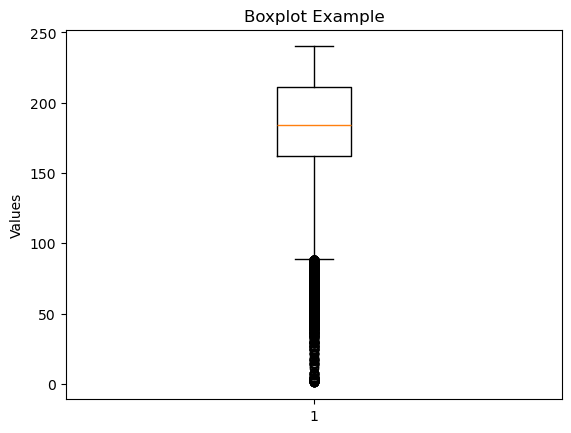

In [55]:
plt.boxplot(df1["Passengers"])

# Add title and labels
plt.title('Boxplot Example')
plt.ylabel('Values')

# Show the plot
plt.show()

In [56]:

Q1 = df1["Passengers"].quantile(0.25)
Q3 = df1["Passengers"].quantile(0.75)
IQR = Q3 - Q1

# Define the boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where the column value is outside the boundaries
df_filtered1 = df1[(df1["Passengers"] >= lower_bound) & (df1["Passengers"] <= upper_bound)]


In [57]:
df = df_filtered1

In [70]:
df

,Flight_ID,Capacity,Passengers,Bookings,tiempoVuelo,Destination_Type_Ciudad Fronteriza,Destination_Type_Ciudad Principal,Destination_Type_Ecoturismo,Destination_Type_MX Amigos y Familia,Destination_Type_Playa,...,day_of_week_sinSalida,day_of_week_cosSalida,month_sinSalida,month_cosSalida,hour_sinLlegada,hour_cosLlegada,day_of_week_sinLlegada,day_of_week_cosLlegada,month_sinLlegada,month_cosLlegada
0,ab954014077430bd842cfa305a55c0f8,240,229.0,157.0,165.0,True,False,False,False,False,...,0.433884,-0.900969,-8.660254e-01,5.000000e-01,-0.500000,-8.660254e-01,0.433884,-0.900969,-8.660254e-01,5.000000e-01
1,efd86c996035dacdca7a0ccb2560dda1,186,186.0,109.0,240.0,False,False,False,True,False,...,0.000000,1.000000,-5.000000e-01,-8.660254e-01,0.866025,5.000000e-01,0.000000,1.000000,-5.000000e-01,-8.660254e-01
3,dd0fad3248951d2f71d63e6279aeaa4b,220,200.0,142.0,40.0,False,False,False,True,False,...,0.000000,1.000000,1.224647e-16,-1.000000e+00,-0.707107,-7.071068e-01,0.000000,1.000000,1.224647e-16,-1.000000e+00
4,d0987ee648eea254063bfe2b39571b67,186,162.0,90.0,70.0,False,False,False,False,True,...,-0.433884,-0.900969,8.660254e-01,5.000000e-01,0.707107,-7.071068e-01,-0.433884,-0.900969,8.660254e-01,5.000000e-01
5,3b5df8805161ea827d2f2e4298c38e06,240,183.0,125.0,55.0,False,False,False,False,True,...,0.433884,-0.900969,-1.000000e+00,-1.836970e-16,-1.000000,-1.836970e-16,0.433884,-0.900969,-1.000000e+00,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245718,d9ef769565064b1ff1ad90d6d18f69cb,180,166.0,89.0,230.0,False,False,False,False,True,...,0.781831,0.623490,-2.449294e-16,1.000000e+00,0.500000,-8.660254e-01,0.781831,0.623490,-2.449294e-16,1.000000e+00
245745,598035669a4f0fa2ce1207977932df9e,180,142.0,54.0,205.0,False,False,False,False,True,...,0.433884,-0.900969,-2.449294e-16,1.000000e+00,-0.258819,-9.659258e-01,0.433884,-0.900969,-2.449294e-16,1.000000e+00
245747,90d2cab80b7700b5d854ae393678144b,180,156.0,61.0,195.0,False,False,False,False,True,...,-0.974928,-0.222521,-2.449294e-16,1.000000e+00,-0.707107,-7.071068e-01,-0.974928,-0.222521,-2.449294e-16,1.000000e+00
245748,cc7c1c5e6fd132fd0bdab3a35aac33c0,240,189.0,86.0,440.0,False,False,False,False,True,...,-0.433884,-0.900969,-2.449294e-16,1.000000e+00,-0.500000,-8.660254e-01,-0.433884,-0.900969,-2.449294e-16,1.000000e+00


# Modelo final

In [58]:
y = df[["Passengers", "Bookings"]].values
X = df.drop(columns=["Passengers", "Bookings", "Flight_ID"])

Se es escalan los datos, ya que consideramos que era importante para la red neuronal. Contruimos una red neuronal de tipo secuencial con un autput de dos valores, pasajeros y bookings, con tres layers doptamos el optimizador de tipo Adam. Los layers son de tipo no lineal, para decidir y llegar a una concluión the tipo lineal. Se decidió calcular el MAE y el R2 para juzgar el modelo.

In [59]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score


# Supongamos que tu DataFrame `df` contiene las variables X e Y

# Preprocesamiento
scaler_X = StandardScaler()  # O MinMaxScaler()
scaler_Y = StandardScaler()  # O MinMaxScaler()

# Separar el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_Y.fit_transform(y_train)
y_test_scaled = scaler_Y.transform(y_test)

# Construcción del modelo
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')  # Salida para dos columnas (regresión)
])

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Callbacks para EarlyStopping y guardar el mejor modelo
#early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenamiento del modelo
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32,
                    validation_split=0.1)

# Evaluación del modelo
loss, mae = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Loss: {loss}, Test MAE: {mae}')

# Predicción y desescalado para obtener resultados en la escala original
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_Y.inverse_transform(y_pred_scaled)

# Métricas adicionales
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}, R2 Score: {r2}')

Epoch 1/100


/opt/anaconda3/envs/tecmx/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2702/2702 ━━━━━━━━━━━━━━━━━━━━ 2s 460us/step - loss: 0.6900 - mae: 0.6526 - val_loss: 0.5651 - val_mae: 0.5934
Epoch 2/100
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 0.5810 - mae: 0.5976 - val_loss: 0.5409 - val_mae: 0.5790
Epoch 3/100
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - loss: 0.5687 - mae: 0.5916 - val_loss: 0.5358 - val_mae: 0.5734
Epoch 4/100
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - loss: 0.5581 - mae: 0.5846 - val_loss: 0.5404 - val_mae: 0.5778
Epoch 5/100
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - loss: 0.5541 - mae: 0.5827 - val_loss: 0.5225 - val_mae: 0.5607
Epoch 6/100
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 1s 439us/step - loss: 0.5426 - mae: 0.5775 - val_loss: 0.5151 - val_mae: 0.5566
Epoch 7/100
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step - loss: 0.5409 - mae: 0.5742 - val_loss: 0.5211 - val_mae: 0.5645
Epoch 8/100
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - loss: 0.5345 - mae: 0.5708 - val_loss: 0.5124 - val_mae: 0.5597
Epoch 9/100
2702/2702 ━━━━━━

Consideramos que el modelo es óptimo, ya que aunque el MSE es alto, consideramos que para el contexto del proyecto y la información proporcionada, es un rango de error aceptable. Sin embargo, esto se ve reflejado en el R2 score ya que es bajo, pero esto lo podemos atribuir a que existen épocas, descuentos y otro tipo de cosas que es más dificil cuantificar para calcular el numero de personas que vuelan.

In [60]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,808 (159.41 KB)

 Trainable params: 13,602 (53.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,206 (106.28 KB)

  1/751 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step

751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


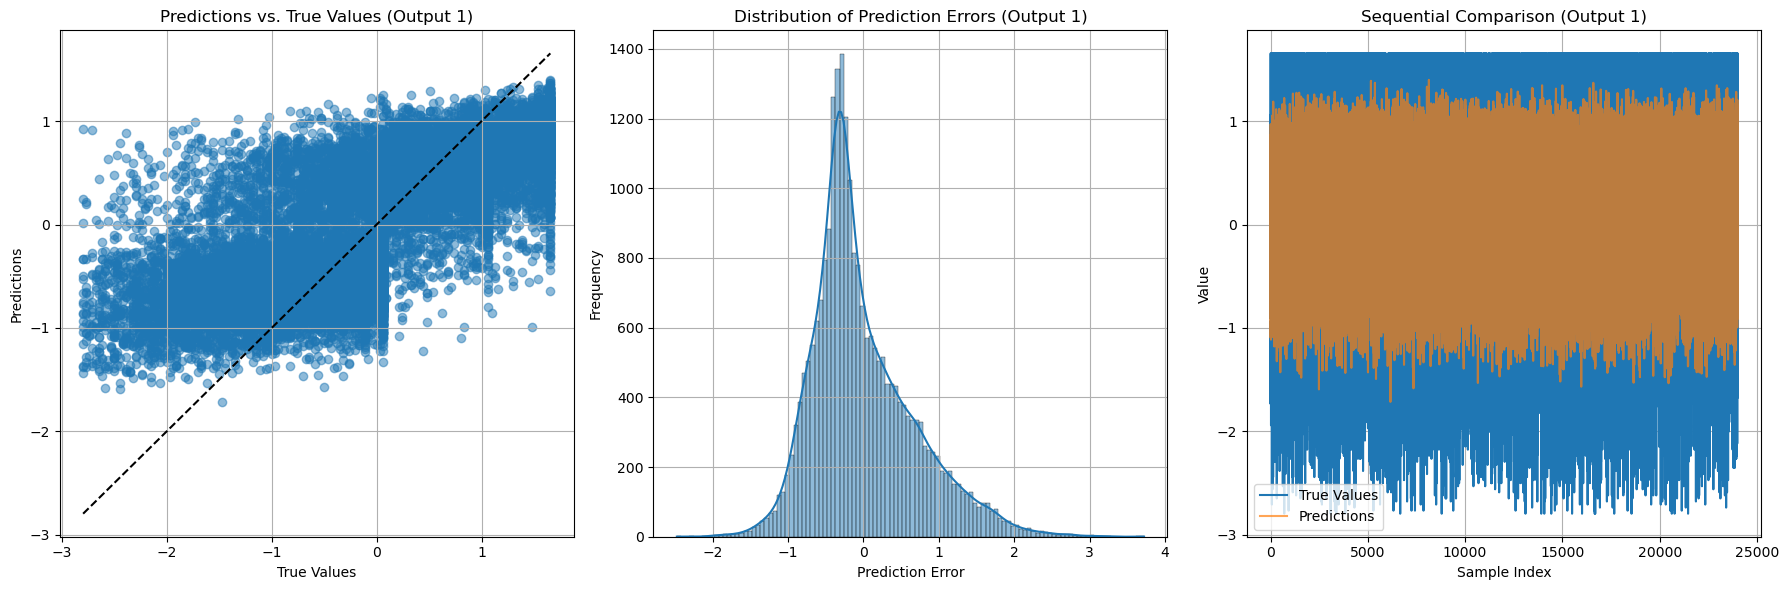

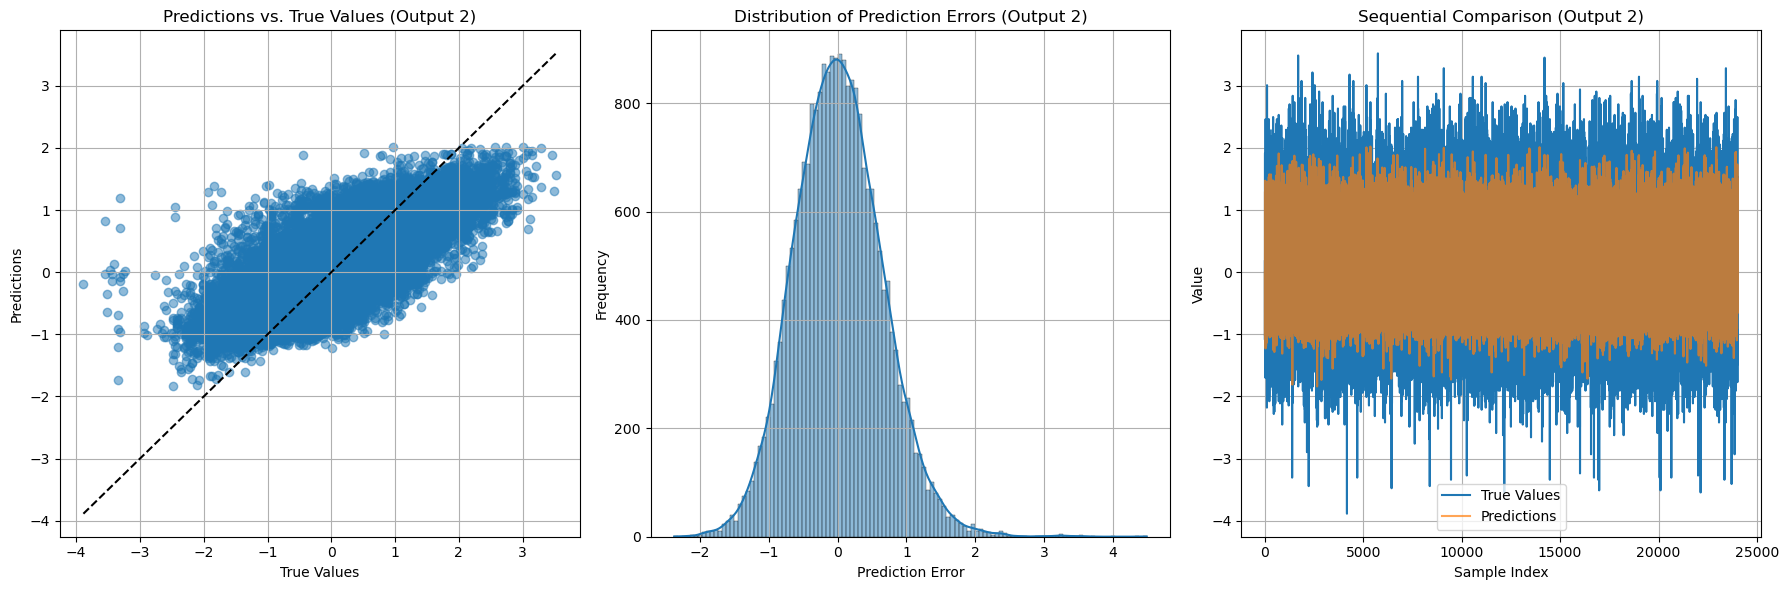

In [61]:


# Assuming model is already trained
predictions = model.predict(X_test_scaled)
num_outputs = y_test_scaled.shape[1]  # Number of output dimensions

# Loop through each output dimension
for i in range(num_outputs):
    true_values = y_test_scaled[:, i]
    predicted_values = predictions[:, i]

    # Create subplots: 1 row, 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Scatter Plot of Predictions vs True Values
    axs[0].scatter(true_values, predicted_values, alpha=0.5)
    axs[0].set_title(f'Predictions vs. True Values (Output {i+1})')
    axs[0].set_xlabel('True Values')
    axs[0].set_ylabel('Predictions')
    axs[0].plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--')  # Diagonal line
    axs[0].grid(True)

    # Histogram of Prediction Errors
    errors = predicted_values - true_values
    sns.histplot(errors, kde=True, ax=axs[1])
    axs[1].set_title(f'Distribution of Prediction Errors (Output {i+1})')
    axs[1].set_xlabel('Prediction Error')
    axs[1].set_ylabel('Frequency')
    axs[1].grid(True)

    # Line Plot for Sequential Data
    axs[2].plot(true_values, label='True Values')
    axs[2].plot(predicted_values, label='Predictions', alpha=0.7)
    axs[2].set_title(f'Sequential Comparison (Output {i+1})')
    axs[2].set_xlabel('Sample Index')
    axs[2].set_ylabel('Value')
    axs[2].legend()
    axs[2].grid(True)

    # Show plots
    plt.tight_layout()
    plt.show()


Con las gráficas podemos ver que la distribución de los resultados se centran más en el la línea, lo cual es bueno para el modelo, ya que la mayoria se concentra en el valor real. Por otra parte, existen predictiones que son muy afeura del valor real, esto hace que el MSE crezca y causa que no se aprecie tanto la concentración en las buenas preddicones. 

In [62]:
datos2024.reset_index(drop=True, inplace=True)

In [63]:
y_pred


array([[168.08371 , 114.904465],
       [146.77089 ,  99.22917 ],
       [170.75937 ,  84.815544],
       ...,
       [221.03925 , 146.78294 ],
       [182.823   , 131.41948 ],
       [207.09865 , 122.527176]], dtype=float32)

In [64]:
datos2024_X=datos2024.drop(columns=['Flight_ID','Passengers','Bookings'])


In [65]:
datos2024_X

,Capacity,tiempoVuelo,Destination_Type_Ciudad Fronteriza,Destination_Type_Ciudad Principal,Destination_Type_Ecoturismo,Destination_Type_MX Amigos y Familia,Destination_Type_Playa,Origin_Type_Ciudad Fronteriza,Origin_Type_Ciudad Principal,Origin_Type_Ecoturismo,...,day_of_week_sinSalida,day_of_week_cosSalida,month_sinSalida,month_cosSalida,hour_sinLlegada,hour_cosLlegada,day_of_week_sinLlegada,day_of_week_cosLlegada,month_sinLlegada,month_cosLlegada
0,180,75.0,False,False,False,False,True,False,True,False,...,0.974928,-0.222521,0.5,0.866025,-0.866025,-0.500000,0.974928,-0.222521,0.5,0.866025
1,180,45.0,False,False,False,False,True,False,True,False,...,0.000000,1.000000,0.5,0.866025,-0.258819,-0.965926,0.000000,1.000000,0.5,0.866025
2,180,75.0,False,False,False,False,True,False,True,False,...,0.433884,-0.900969,0.5,0.866025,-0.866025,-0.500000,0.433884,-0.900969,0.5,0.866025
3,186,100.0,True,False,False,False,False,False,True,False,...,0.781831,0.623490,0.5,0.866025,0.500000,-0.866025,0.781831,0.623490,0.5,0.866025
4,180,50.0,False,False,False,True,False,False,True,False,...,0.000000,1.000000,0.5,0.866025,-0.866025,0.500000,0.000000,1.000000,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709,180,200.0,False,False,False,False,True,False,True,False,...,-0.781831,0.623490,0.5,0.866025,-0.500000,-0.866025,-0.781831,0.623490,0.5,0.866025
1710,240,180.0,False,False,False,False,True,False,True,False,...,-0.433884,-0.900969,0.5,0.866025,-0.707107,-0.707107,-0.433884,-0.900969,0.5,0.866025
1711,240,180.0,False,False,False,False,True,False,True,False,...,-0.433884,-0.900969,0.5,0.866025,-0.707107,-0.707107,-0.433884,-0.900969,0.5,0.866025
1712,240,180.0,False,False,False,False,True,False,True,False,...,0.974928,-0.222521,0.5,0.866025,-0.707107,-0.707107,0.974928,-0.222521,0.5,0.866025


In [66]:
X_datos2024_scaled = scaler_X.fit_transform(datos2024_X)
y_pred_2024_scaled = model.predict(X_datos2024_scaled)
y_pred_2024 = scaler_Y.inverse_transform(y_pred_2024_scaled)
y_pred_2024


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


array([[162.3134  ,  99.382774],
       [161.77855 ,  92.7487  ],
       [170.44344 , 107.50959 ],
       ...,
       [208.07932 , 119.40146 ],
       [210.49028 , 130.33627 ],
       [209.51456 , 125.24703 ]], dtype=float32)

In [67]:
datos2024_final=datos2024.drop(columns=['Passengers','Bookings'])

y_pred_2024 = np.round(y_pred_2024).astype(int)

# Crear un DataFrame temporal con los nombres deseados
df_temp = pd.DataFrame(y_pred_2024, columns=["Expected_Passengers", "Expected_Bookings"])

df_final = pd.concat([datos2024_final.reset_index(drop=True), df_temp], axis=1)


In [68]:
df_final

,Flight_ID,Capacity,tiempoVuelo,Destination_Type_Ciudad Fronteriza,Destination_Type_Ciudad Principal,Destination_Type_Ecoturismo,Destination_Type_MX Amigos y Familia,Destination_Type_Playa,Origin_Type_Ciudad Fronteriza,Origin_Type_Ciudad Principal,...,month_sinSalida,month_cosSalida,hour_sinLlegada,hour_cosLlegada,day_of_week_sinLlegada,day_of_week_cosLlegada,month_sinLlegada,month_cosLlegada,Expected_Passengers,Expected_Bookings
0,c8e2539e6b04432617d945b30bdd9d69,180,75.0,False,False,False,False,True,False,True,...,0.5,0.866025,-0.866025,-0.500000,0.974928,-0.222521,0.5,0.866025,162,99
1,5717f9937ebe931d3b285ae4c193bb6b,180,45.0,False,False,False,False,True,False,True,...,0.5,0.866025,-0.258819,-0.965926,0.000000,1.000000,0.5,0.866025,162,93
2,dbddb026c6d57cd24ea29936ea5cd171,180,75.0,False,False,False,False,True,False,True,...,0.5,0.866025,-0.866025,-0.500000,0.433884,-0.900969,0.5,0.866025,170,108
3,cfae882b6e5a25c979a7455989db993e,186,100.0,True,False,False,False,False,False,True,...,0.5,0.866025,0.500000,-0.866025,0.781831,0.623490,0.5,0.866025,173,107
4,c6eb44f49d835a76c865c75d1026aa25,180,50.0,False,False,False,True,False,False,True,...,0.5,0.866025,-0.866025,0.500000,0.000000,1.000000,0.5,0.866025,172,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709,764f5b604b85a8fd0e88a941139aefc2,180,200.0,False,False,False,False,True,False,True,...,0.5,0.866025,-0.500000,-0.866025,-0.781831,0.623490,0.5,0.866025,177,106
1710,165c65a0cc06f7bd9cc4515a2b7eedb7,240,180.0,False,False,False,False,True,False,True,...,0.5,0.866025,-0.707107,-0.707107,-0.433884,-0.900969,0.5,0.866025,208,119
1711,629413c278109e02284933edba9cff60,240,180.0,False,False,False,False,True,False,True,...,0.5,0.866025,-0.707107,-0.707107,-0.433884,-0.900969,0.5,0.866025,208,119
1712,641573d2c38d4990397c7eb95100cd7a,240,180.0,False,False,False,False,True,False,True,...,0.5,0.866025,-0.707107,-0.707107,0.974928,-0.222521,0.5,0.866025,210,130


In [69]:
df_final.to_csv('dataset2024_pass_predicted.csv', index=False)